# **Cultural Bias Classification - Training - Yelizaveta Tskhe**




## IMPORTS




In [ ]:
!pip install datasets
!pip install wikidata --quiet
!pip install SPARQLWrapper
!pip install transformers
!pip install accelerate -U
!pip install evaluate

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
The token `mytoken` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pu

In [ ]:
import time
import random
import json
import os
from functools import lru_cache
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.model_selection import cross_val_score
import re
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed
)
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import joblib
from datasets import load_dataset

## NON-LM-BASED APPROACH

loading data
processed 0 samples...
processed 1000 samples...
processed 2000 samples...
processed 3000 samples...
processed 4000 samples...
processed 5000 samples...
processed 6000 samples...
processed 0 samples...

accuracy: 0.6467
                         precision    recall  f1-score   support

      cultural agnostic       0.81      0.86      0.83       117
     cultural exclusive       0.48      0.76      0.59        76
cultural representative       0.66      0.33      0.44       107

               accuracy                           0.65       300
              macro avg       0.65      0.65      0.62       300
           weighted avg       0.67      0.65      0.63       300


stage 1 (ca vs nonca):
              precision    recall  f1-score   support

          CA       0.82      0.86      0.84       117
      non-CA       0.91      0.88      0.89       183

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg 

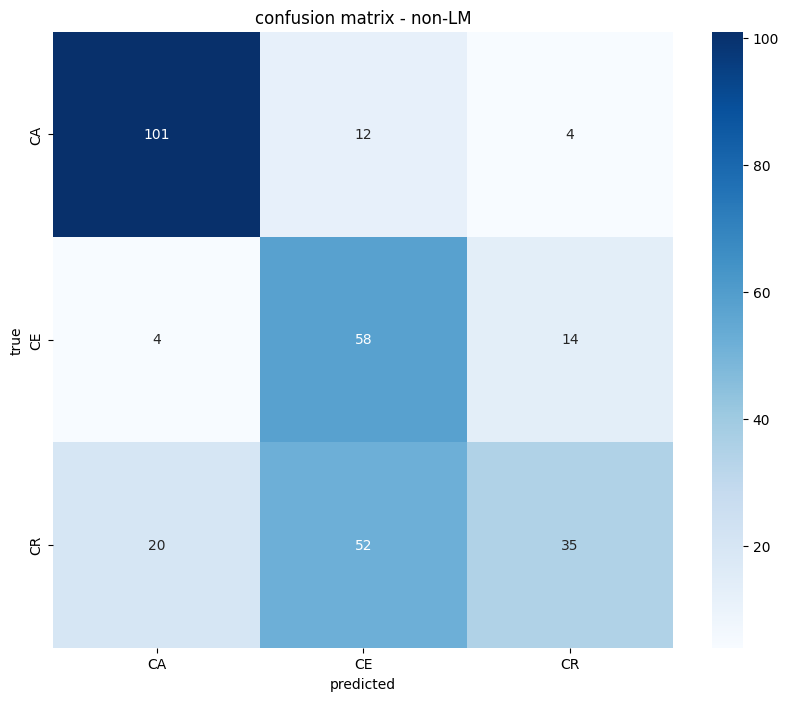

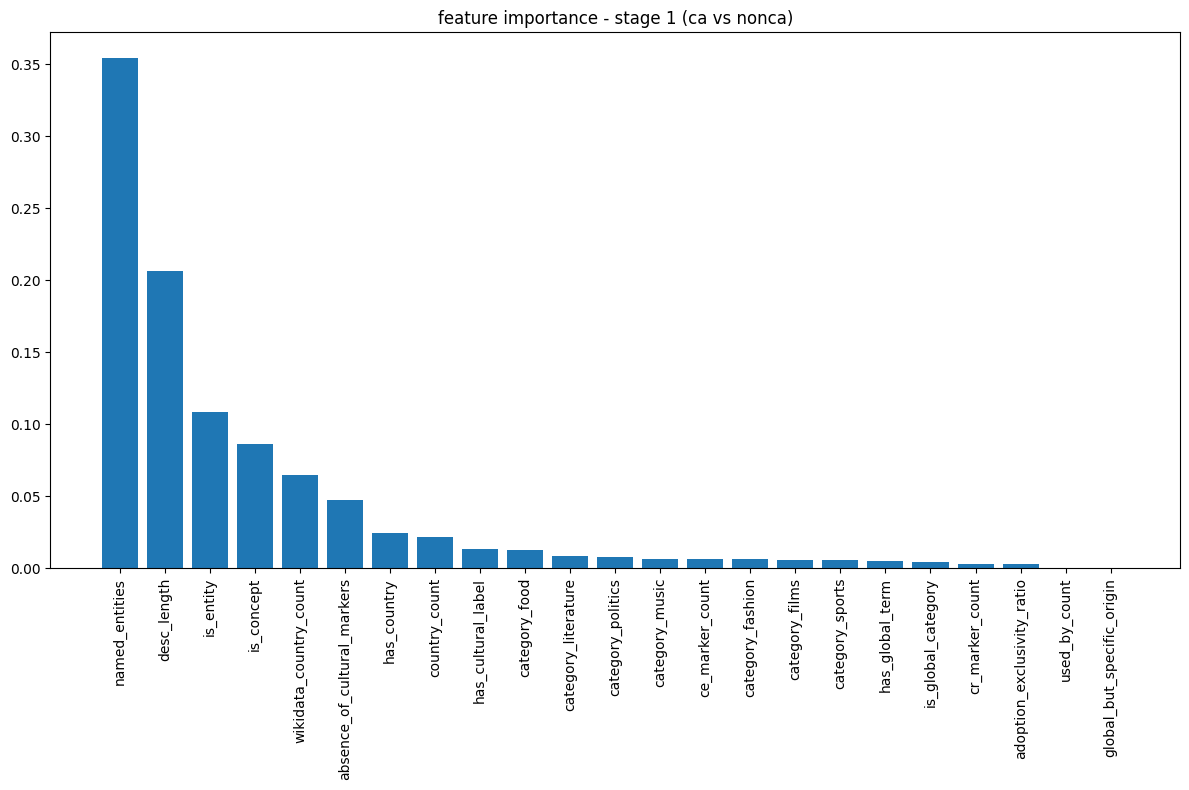

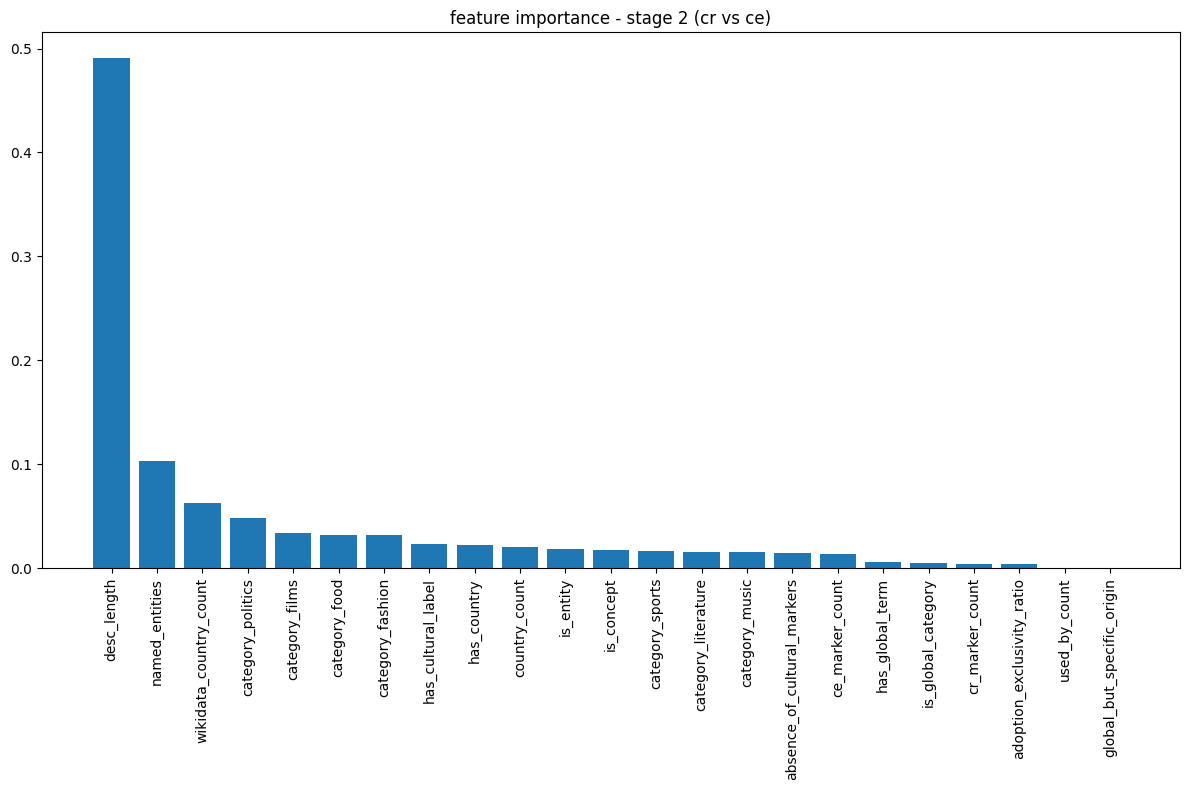

In [ ]:
CACHE_FILE = "wikidata_cache.json"

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, 'r') as f:
        wikidata_cache = json.load(f)
else:
    wikidata_cache = {}

def get_wikidata_category_info(wikidata_id, max_retries=3):
    if wikidata_id in wikidata_cache:
        return wikidata_cache[wikidata_id]["values"], wikidata_cache[wikidata_id]["property_values"]

    wikidata_id_clean = wikidata_id.split("/")[-1]  # clean ID

    try:
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        sparql.addCustomHttpHeader("User-Agent", "CulturalClassifier/1.0 (research-project)")

        query = f"""
        SELECT ?propertyLabel ?valueLabel WHERE {{
          VALUES ?prop {{
            wdt:P31  # instance of
            wdt:P279  # subclass of
            wdt:P495  # country of origin
            wdt:P27  # country of citizenship
            wdt:P361  # part of
            wdt:P1535  # used by
            wdt:P131  # located in administrative territory
            wdt:P17  # country
            wdt:P276  # location
            wdt:P3342  # significant place
          }}
          wd:{wikidata_id_clean} ?prop ?value .
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language 'en'. }}
        }}
        LIMIT 20
        """

        for attempt in range(max_retries):
            try:
                sparql.setQuery(query)
                sparql.setReturnFormat(JSON)
                results = sparql.query().convert()

                values = [result["valueLabel"]["value"].lower() for result in results["results"]["bindings"]]
                property_values = []
                for result in results["results"]["bindings"]:
                    property_values.append({
                        "property": result["propertyLabel"]["value"].lower() if "propertyLabel" in result else "",
                        "value": result["valueLabel"]["value"].lower() if "valueLabel" in result else ""
                    })

                # cache the results
                wikidata_cache[wikidata_id] = {
                    "values": values,
                    "property_values": property_values
                }

                # save to cache file occasionally
                if random.random() < 0.01:
                    with open(CACHE_FILE, 'w') as f:
                        json.dump(wikidata_cache, f)

                return values, property_values

            except Exception as e:
                if "429" in str(e):
                    wait_time = 2 ** attempt
                    print(f"Rate limit hit for {wikidata_id_clean}, waiting {wait_time}s...")
                    time.sleep(wait_time)
                else:
                    print(f"SPARQL error for {wikidata_id_clean}: {e}")
                    break

        print(f"All SPARQL attempts failed for {wikidata_id_clean}")
        return [], []

    except Exception as e:
        print(f"SPARQL setup error for {wikidata_id_clean}: {e}")
        return [], []

def extract_features_with_wikidata(sample):
    is_entity = 1 if sample['type'] == 'entity' else 0
    is_concept = 1 if sample['type'] == 'concept' else 0
    desc_length = len(sample['description'])

    categories = ['politics', 'food', 'fashion', 'sports', 'music', 'films', 'literature']
    category_features = [1 if sample['category'] == cat else 0 for cat in categories]

    description = sample['description'].lower()
    common_countries = ["italy", "france", "japan", "china", "india", "germany", "spain", "brazil", "mexico",
                       "american", "european", "african", "asian", "australia", "canada", "russia"]
    has_country = int(any(country in description for country in common_countries))

    global_keywords = ["global", "universal", "worldwide", "international",
                       "common", "general", "standard", "widely used", "across cultures",
                       "ubiquitous", "everywhere", "throughout the world", "many countries"]
    has_global_term = int(any(term in description for term in global_keywords))

    # number of different countries/regions mentioned
    country_count = sum(country in description for country in common_countries)

    try:
        wikidata_values, property_values = get_wikidata_category_info(sample['item'])
    except Exception as e:
        print(f"Error in Wikidata query: {e}")
        wikidata_values, property_values = [], []

    # unique cultures/countries in Wikidata
    country_entities = set()
    for value in wikidata_values:
        for country in common_countries:
            if country in value.lower():
                country_entities.add(country)
    wikidata_country_count = len(country_entities)

    cultural_keywords = ["culture", "heritage", "tradition", "ethnic", "korean", "japanese", "french",
                        "italian", "german", "american", "african", "traditional", "indigenous"]
    has_cultural_label = int(any(kw in value for value in wikidata_values for kw in cultural_keywords))

    # for agnostic items
    absence_of_cultural_markers = 1 if not has_cultural_label and not has_country else 0

    # "used by" property with multiple values (indicates spread)
    used_by_count = sum(1 for pv in property_values if "used by" in pv["property"])

    # global categories like "tool" or "equipment" tend to be culturally agnostic
    global_categories = ["tool", "equipment", "device", "instrument", "technology", "scientific", "mathematical"]
    is_global_category = int(any(gc in value for value in wikidata_values for gc in global_categories))

    # items with global usage but specific origin
    has_origin = int(any("origin" in pv["property"] for pv in property_values))
    global_but_specific_origin = 1 if has_global_term and has_origin else 0

    cr_markers = ["widespread", "popular", "common", "adopted", "adapted",
                 "international", "regional", "variant", "inspired", "influence"]
    cr_marker_count = sum(term in description for term in cr_markers)

    ce_markers = ["unique", "exclusive", "specific", "only", "indigenous",
                 "traditional", "native", "authentic", "original", "exclusive to"]
    ce_marker_count = sum(term in description for term in ce_markers)

    adoption_exclusivity_ratio = cr_marker_count / max(ce_marker_count, 1)

    # ce (more specific locations/cultures)
    named_entities = len(re.findall(r'[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*', sample['description']))

    return [is_entity, is_concept, desc_length, has_country, has_cultural_label,
            has_global_term, country_count, wikidata_country_count, absence_of_cultural_markers,
            used_by_count, is_global_category, global_but_specific_origin,
            cr_marker_count, ce_marker_count, adoption_exclusivity_ratio, named_entities] + category_features

def create_dataset(dataset, split, max_samples=None):
    if max_samples is None:
        max_samples = len(dataset[split])

    feature_names = ['is_entity', 'is_concept', 'desc_length', 'has_country', 'has_cultural_label',
                     'has_global_term', 'country_count', 'wikidata_country_count', 'absence_of_cultural_markers',
                     'used_by_count', 'is_global_category', 'global_but_specific_origin',
                     'cr_marker_count', 'ce_marker_count', 'adoption_exclusivity_ratio', 'named_entities',
                     'category_politics', 'category_food', 'category_fashion',
                     'category_sports', 'category_music', 'category_films',
                     'category_literature']

    X, y, ids = [], [], []

    for i in range(min(max_samples, len(dataset[split]))):
        sample = dataset[split][i]
        features = extract_features_with_wikidata(sample)
        X.append(features)
        y.append(sample['label'])
        ids.append(sample['item'])

        if i % 1000 == 0:
            print(f"processed {i} samples...")
            with open(CACHE_FILE, 'w') as f: #save cache periodically
                json.dump(wikidata_cache, f)

    return np.array(X), y, ids, feature_names

# first stage: CA vs non-CA
def train_two_stage_model(X_train, y_train):
    model_stage1 = RandomForestClassifier(
        n_estimators=150,
        random_state=42,
        max_features='sqrt',
        min_samples_leaf=2,
        criterion='entropy',
        class_weight={'CA': 2.0, 'non-CA': 1.0}
    )

    #labels for first stage
    y_train_ca_nonca = ['CA' if label == 'cultural agnostic' else 'non-CA' for label in y_train]
    model_stage1.fit(X_train, y_train_ca_nonca)

    # second stage: cr vs ce
    non_ca_indices = [i for i, label in enumerate(y_train) if label != 'cultural agnostic']
    X_train_cr_ce = X_train[non_ca_indices]
    y_train_cr_ce = [y_train[i] for i in non_ca_indices]

    model_stage2 = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        max_features='sqrt',
        min_samples_leaf=2,
        criterion='entropy',
        class_weight={'cultural exclusive': 1.3, 'cultural representative': 1.2}
    )

    model_stage2.fit(X_train_cr_ce, y_train_cr_ce)

    return model_stage1, model_stage2

def predict_two_stage(X, model_stage1, model_stage2):
    stage1_preds = model_stage1.predict(X)

    final_preds = ['cultural agnostic' if pred == 'CA' else None for pred in stage1_preds]

    non_ca_indices = [i for i, pred in enumerate(stage1_preds) if pred == 'non-CA']

    if len(non_ca_indices) > 0:
        X_non_ca = X[non_ca_indices]
        stage2_preds = model_stage2.predict(X_non_ca)

        for idx, pred in zip(non_ca_indices, stage2_preds):
            final_preds[idx] = pred

    return final_preds

def post_process_cr_ce_predictions(predictions, X_val, feature_names):
    adjusted_predictions = predictions.copy()

    for i in range(len(predictions)):
        # convert features array to dictionary for easier access
        features = dict(zip(feature_names, X_val[i]))

        # rule 1
        if features.get('has_global_term', 0) == 1 and features.get('has_cultural_label', 0) == 0:
            adjusted_predictions[i] = 'cultural agnostic'

        # rule 2: many countries mentioned -> CA
        if features.get('country_count', 0) >= 3 or features.get('wikidata_country_count', 0) >= 3:
            adjusted_predictions[i] = 'cultural agnostic'

        # rule 3: global category items -> CA
        if features.get('is_global_category', 0) == 1 and features.get('has_cultural_label', 0) == 0:
            adjusted_predictions[i] = 'cultural agnostic'

        if adjusted_predictions[i] != 'cultural agnostic':
            # rule 1: high adoption ratio -> ce
            if features.get('adoption_exclusivity_ratio', 0) > 2.0:
                adjusted_predictions[i] = 'cultural representative'

            # rule 2: high exclusivity marker -> ce
            if features.get('ce_marker_count', 0) > 3 and features.get('cr_marker_count', 0) < 2:
                adjusted_predictions[i] = 'cultural exclusive'

            # rule 3: high named entity -> ce
            if features.get('named_entities', 0) > 3:
                adjusted_predictions[i] = 'cultural exclusive'

    return adjusted_predictions

def main():

    print("loading data")
    dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

    X_train, y_train, train_ids, feature_names = create_dataset(dataset, 'train')
    X_val, y_val, val_ids, _ = create_dataset(dataset, 'validation')

    model_stage1, model_stage2 = train_two_stage_model(X_train, y_train)

    joblib.dump(model_stage1, 'model_stage1_nonlm.pkl')
    joblib.dump(model_stage2, 'model_stage2_nonlm.pkl')

    y_pred = predict_two_stage(X_val, model_stage1, model_stage2)

    y_pred = post_process_cr_ce_predictions(y_pred, X_val, feature_names)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"\naccuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

    y_val_binary = ['CA' if label == 'cultural agnostic' else 'non-CA' for label in y_val]
    stage1_preds = model_stage1.predict(X_val)
    print("\nstage 1 (ca vs nonca):")
    print(classification_report(y_val_binary, stage1_preds))

    non_ca_indices_val = [i for i, label in enumerate(y_val) if label != 'cultural agnostic']
    if len(non_ca_indices_val) > 0:
        X_val_non_ca = X_val[non_ca_indices_val]
        y_val_non_ca = [y_val[i] for i in non_ca_indices_val]
        stage2_preds = model_stage2.predict(X_val_non_ca)
        print("\nstage 2 (cr vs ce):")
        print(classification_report(y_val_non_ca, stage2_preds))

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CA', 'CE', 'CR'],
                yticklabels=['CA', 'CE', 'CR'])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title('confusion matrix - non-LM')
    plt.savefig('confusion_matrix-nonlm.png')

    plt.figure(figsize=(12, 8))
    importances = model_stage1.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.title('feature importance - stage 1 (ca vs nonca)')
    plt.tight_layout()
    plt.savefig('feature_importance_stage1.png')

    plt.figure(figsize=(12, 8))
    importances = model_stage2.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.title('feature importance - stage 2 (cr vs ce)')
    plt.tight_layout()
    plt.savefig('feature_importance_stage2.png')

    error_analysis = []
    for i, (true, pred) in enumerate(zip(y_val, y_pred)):
        if true != pred:
            sample_idx = i if i < len(dataset['validation']) else i % len(dataset['validation'])
            sample = dataset['validation'][sample_idx]
            error_analysis.append({
                'item': sample['item'],
                'name': sample['name'],
                'description': sample['description'],
                'type': sample['type'],
                'category': sample['category'],
                'true_label': true,
                'predicted_label': pred
            })
    error_df = pd.DataFrame(error_analysis)
    error_df.to_csv('error_analysis.csv', index=False)

    cr_as_ce = error_df[(error_df['true_label'] == 'cultural representative') &
                        (error_df['predicted_label'] == 'cultural exclusive')]
    cr_as_ce.to_csv('cr_as_ce_errors.csv', index=False)
    print(f"\nCR misclassified as CE: {len(cr_as_ce)}")

    ce_as_cr = error_df[(error_df['true_label'] == 'cultural exclusive') &
                        (error_df['predicted_label'] == 'cultural representative')]
    ce_as_cr.to_csv('ce_as_cr_errors.csv', index=False)
    print(f"\nCE misclassified as CR: {len(ce_as_cr)}")

    output_data = []
    for i in range(len(y_pred)):
        sample_idx = i if i < len(dataset['validation']) else i % len(dataset['validation'])
        sample = dataset['validation'][sample_idx]
        output_data.append({
            'item': sample['item'],
            'name': sample['name'],
            'description': sample['description'],
            'type': sample['type'],
            'category': sample['category'],
            'true_label': y_val[i],
            'predicted_label': y_pred[i]
        })

    output_df = pd.DataFrame(output_data)
    output_df.to_csv('val_output_nonlm.csv', index=False)

    print("Saved as 'val_output_nonlm.csv'.")

    print("\nsummary:")
    print(f"total: {len(y_val)}")
    print(f"correctly classified: {sum(np.array(y_val) == y_pred)}")
    print(f"misclassified: {sum(np.array(y_val) != y_pred)}")
    print(f"accuracy: {accuracy:.4f}")

    print("\nclass distribution:")
    train_distribution = pd.Series(y_train).value_counts(normalize=True)
    val_distribution = pd.Series(y_val).value_counts(normalize=True)
    pred_distribution = pd.Series(y_pred).value_counts(normalize=True)

    dist_df = pd.DataFrame({
        'training set': train_distribution,
        'validation set': val_distribution,
        'predictions': pred_distribution
    })
    print(dist_df)

if __name__ == "__main__":
    main()

## LM-BASED APPROACH

In [ ]:
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("loading datsset")
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

def preprocess(example):
    example["text"] = f"{example['name']} {example['description']} {example['category']} {example['subcategory']}"
    return example

dataset = dataset.map(preprocess)

# encode string labels into integers
label_names = ["cultural agnostic", "cultural representative", "cultural exclusive"]
label_to_id = {label: i for i, label in enumerate(label_names)}
id_to_label = {i: label for label, i in label_to_id.items()}

def encode_labels(example):
    example["label"] = label_to_id[example["label"]]
    return example

dataset = dataset.map(encode_labels)

labels = np.array(dataset["train"]["label"])
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id_to_label,
    label2id=label_to_id
)


def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./results",
    warmup_steps=500,
    save_strategy="no",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


trainer.train()
trainer.evaluate()


model.save_pretrained("./model_distilbert")
tokenizer.save_pretrained("./model_distilbert")
print("model and tokenizer saved to ./model_distilbert")


predictions = trainer.predict(tokenized_dataset["validation"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)

correct = predicted_labels == np.array(dataset["validation"]["label"])
accuracy_score = np.mean(correct)
print(f"\nval accuracy: {accuracy_score:.4f}")


true_labels = np.array(dataset["validation"]["label"])
misclassified_indices = np.where(predicted_labels != true_labels)[0]


misclassified_counts = Counter([true_labels[i] for i in misclassified_indices])
print("\nmisclassified examples per true category:")
for label_id, count in misclassified_counts.items():
    print(f"  {id_to_label[label_id]}: {count} misclassified")


print("\ntotal examples per category (val set):")
label_distribution = Counter(true_labels)
for label_id, count in label_distribution.items():
    print(f"  {id_to_label[label_id]}: {count} total")


df = pd.DataFrame({
    "item": dataset["validation"]["item"],
    "name": dataset["validation"]["name"],
    "description": dataset["validation"]["description"],
    "true_label": [id_to_label[i] for i in dataset["validation"]["label"]],
    "predicted_label": [id_to_label[i] for i in predicted_labels],
})
df.to_csv("distilbert_val_output.csv", index=False)
print("saved to distilbert_val_output.csv")


loading datsset


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-dc85dcc87d4d>:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


model and tokenizer saved to ./no_bias_model_distilbert

val accuracy: 0.7367

misclassified examples per true category:
  cultural representative: 30 misclassified
  cultural exclusive: 37 misclassified
  cultural agnostic: 12 misclassified

total examples per category (val set):
  cultural representative: 107 total
  cultural exclusive: 76 total
  cultural agnostic: 117 total
saved to no_bias_distilbert_val_output.csv


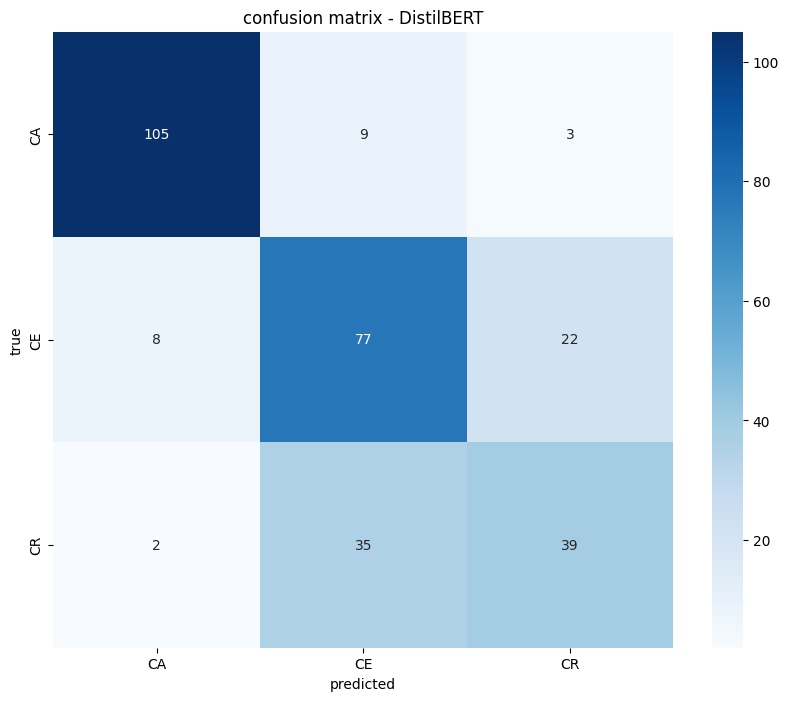

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels, )
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CA', 'CE', 'CR'],
                yticklabels=['CA', 'CE', 'CR'])
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('confusion matrix - DistilBERT')
plt.savefig('confusion_matrix-distilbert.png')


In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=label_names))

                         precision    recall  f1-score   support

      cultural agnostic       0.91      0.90      0.91       117
cultural representative       0.64      0.72      0.68       107
     cultural exclusive       0.61      0.51      0.56        76

               accuracy                           0.74       300
              macro avg       0.72      0.71      0.71       300
           weighted avg       0.74      0.74      0.74       300



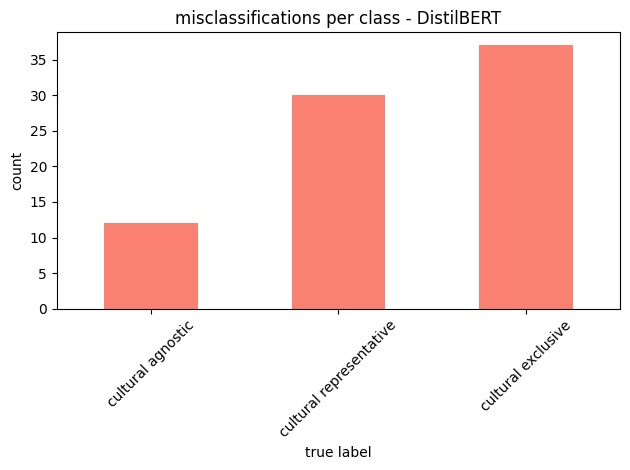

In [ ]:
mis_data = {label: misclassified_counts.get(label_to_id[label], 0) for label in label_names}
mis_df = pd.DataFrame.from_dict(mis_data, orient='index', columns=["count"])

mis_df.plot(kind='bar', color='salmon', legend=False)
plt.title("misclassifications per class - DistilBERT")
plt.ylabel("count")
plt.xlabel("true label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("misclassified_per_class-distilbert.png")
plt.show()



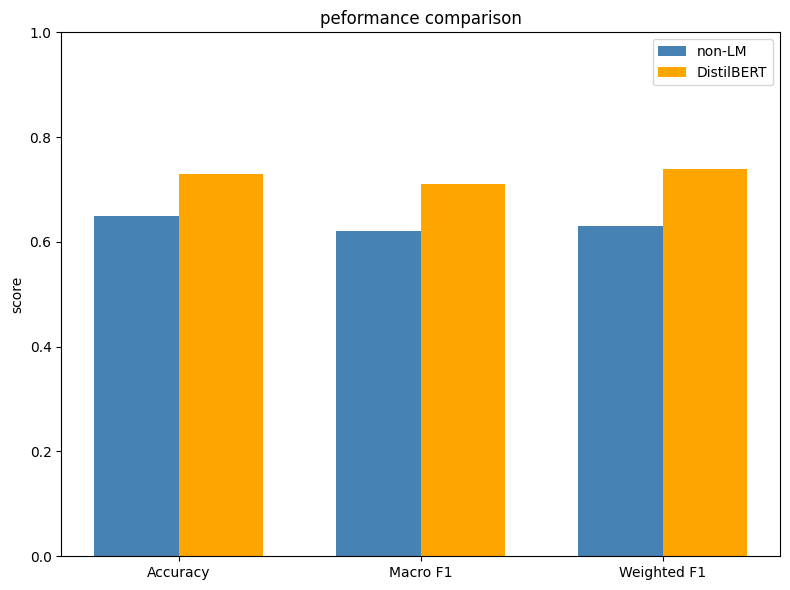

In [ ]:
labels = ['Accuracy', 'Macro F1', 'Weighted F1']
non_lm_scores = [0.65, 0.62, 0.63]
distilbert_scores = [0.73, 0.71, 0.74]

x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar([i - bar_width/2 for i in x], non_lm_scores, width=bar_width, label='non-LM', color='steelblue')
plt.bar([i + bar_width/2 for i in x], distilbert_scores, width=bar_width, label='DistilBERT', color='orange')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("score")
plt.title("peformance comparison")
plt.legend()
plt.tight_layout()
plt.savefig("performance_comparison_distilbert_vs_nonlm.png")
plt.show()
